# Redis as a Vector Database for Face ID Search

In [1]:
import requests
import os
from glob import glob
from gc import collect
import random

import numpy as np
import pandas as pd

import redis
from redis.commands.search.field import (
    NumericField,
    TagField,
    TextField,
    VectorField,
)
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import Query

import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Connect Redis

Instantiate the Redis client. By default, Redis returns binary responses. To decode them, you pass the decode_responses parameter set to True.


In [2]:
client = redis.Redis(host="localhost", port=6379, decode_responses=True)
client

Redis<ConnectionPool<Connection<host=localhost,port=6379,db=0>>>

## Demo Data

Get demo data from https://www.kaggle.com/datasets/atulanandjha/lfwpeople?resource=download&select=lfw-funneled.tgz.

Or run command `./run.sh`

In [3]:
dirPath = "./lfw_funneled"
fileExt = "*.jpg"

In [4]:
# Get total images.
srcFiles = []
dirPath = os.path.abspath(dirPath)
for d in glob(os.path.join(dirPath, "*")):
    if not os.path.isdir(d):
        continue
    try:
        srcFiles.append(glob(os.path.join(d, fileExt))[0])
    except IndexError:
        continue
dataLen = len(srcFiles)
print(dataLen, "images")

5749 images


In [5]:
# Use only 10 images for this experiment.
srcFiles = srcFiles[:min(dataLen, 10)]
dataLen = len(srcFiles)
print(dataLen, "images")

10 images


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_77385/187068727.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


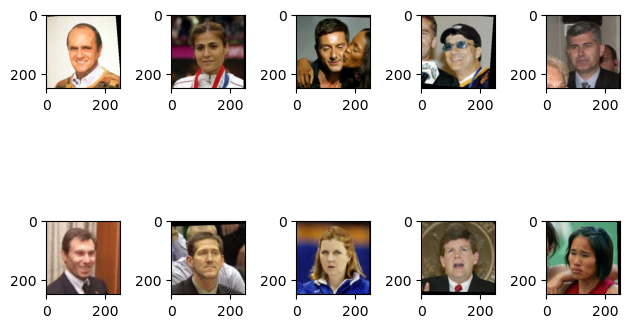

In [6]:
# Show some images.
fig, axes = plt.subplots(2, 5)
axes = axes.ravel()
for ax, file in zip(axes, random.sample(srcFiles, 10)):
    img = cv2.imread(file)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig.tight_layout()
fig.show()

## Store Data

Store person data as JSONs in Redis.

In [7]:
pipeline = client.pipeline()
for i, file in enumerate(srcFiles, start=1):
    redis_key = f"person:{i:03}"
    data = {
        'name': os.path.split(os.path.dirname(file))[-1].replace('_', ' '),
        'file': file
        }
    pipeline.json().set(redis_key, "$", data)
res = pipeline.execute()
res

[True, True, True, True, True, True, True, True, True, True]

## Retrieve Data

Example of retrieving data from Redis.

In [8]:
res = client.json().get("person:001")
res

{'name': 'German Khan',
 'file': '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/German_Khan/German_Khan_0001.jpg'}

## Embeddings

Use an embedder model to get embeddings for each data entry.

MTCNN and FaceNet are used together for face detection and face embedding respectively.

In [9]:
detector = MTCNN()
embedder = InceptionResnetV1(pretrained='vggface2').eval()

In [10]:
keys = sorted(client.keys("person:*"))
keys

['person:001',
 'person:002',
 'person:003',
 'person:004',
 'person:005',
 'person:006',
 'person:007',
 'person:008',
 'person:009',
 'person:010']

In [11]:
srcFiles = client.json().mget(keys, "$.file")
srcFiles = [item for sublist in srcFiles for item in sublist]
srcFiles

['/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/German_Khan/German_Khan_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Stefano_Gabbana/Stefano_Gabbana_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Dragan_Covic/Dragan_Covic_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Jeff_Hornacek/Jeff_Hornacek_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Sureyya_Ayhan/Sureyya_Ayhan_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Deb_Santos/Deb_Santos_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Bob_Newhart/Bob_Newhart_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Wang_Hailan/Wang_Hailan_0001.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Paul_McNulty/Paul_McNulty_0002.jpg',
 '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/Jimmy_Iovine/Jimmy_Iovine_0001.jpg']

In [12]:
batchSize = 16
outputType = np.float32
outputSize = 512

outputs = np.array([], outputType).reshape((0, outputSize))
inputFiles = []

# Iterate over batchs.
maxIdx = dataLen
idx = 0
while idx < maxIdx:
    print(">>> Index:", idx)
    
    inputs = []
    
    # read and stack images into a batch.
    while (len(inputs) < batchSize) and (idx < dataLen):
        file = srcFiles[idx]
        # TODO To improve performance, use cv2.IMREAD_GRAYSCALE.
        img = cv2.imread(file)
        if img is None:
            print(file, "file not found")
            idx += 1
            continue
        # TODO To improve performance, resize.
        
        # can input images as a list of numpy/tensor or numpy/tensor.
        # return a list of tensors.
        img = detector(img)
        if img is None:
            print(file, "face not found")
            idx += 1
            continue
        
        # stack tensors.
        inputs.append(img)
        inputFiles.append(file)
        idx += 1

    # fig, axes = plt.subplots(1, batchSize)
    # for ax, img in zip(axes, inputs):
    #     ax.imshow(img.detach().permute(1,2,0).cpu().numpy())

    inputs = torch.stack(inputs)
    outputs = np.append(outputs, embedder(inputs).detach().cpu().numpy(), 0)
    print("Output length:", outputs.shape)
    collect()


>>> Index: 0
Output length: (10, 512)


In [13]:
outputs = outputs.tolist()
VECTOR_DIMENSION = len(outputs[0])

## Store Embeddings

Store embeddings as a vector in Redis.

In [14]:
pipeline = client.pipeline()
for key, embedding in zip(keys, outputs):
    pipeline.json().set(key, "$.face_embeddings", embedding)
pipeline.execute()

[True, True, True, True, True, True, True, True, True, True]

In [15]:
res = client.json().get("person:001")
res

{'name': 'German Khan',
 'file': '/Users/rapeewannasiri/Projects/FAGIS/data/lfw_funneled/German_Khan/German_Khan_0001.jpg',
 'face_embeddings': [0.02892066352069378,
  -0.03415651619434357,
  0.013112664222717283,
  0.00792048778384924,
  0.0702793225646019,
  -0.007737682666629553,
  -0.03562621772289276,
  0.026369061321020126,
  -0.006787195336073637,
  -0.0032801160123199224,
  0.023460526019334793,
  0.0747683197259903,
  -0.04477812349796295,
  0.05258558690547943,
  -0.051727306097745895,
  0.056161388754844666,
  0.05919113010168075,
  0.0018172214040532708,
  -0.04131193831562996,
  -0.00341792032122612,
  0.058661818504333496,
  0.012240373529493809,
  0.02107737585902214,
  -0.04021574556827545,
  -0.05752682313323021,
  -0.05227015167474747,
  0.06541311740875244,
  0.004169372376054525,
  -0.0006512952386401594,
  0.012400428764522076,
  -0.031623538583517075,
  -0.08095434308052063,
  0.02643672749400139,
  0.015940288081765175,
  0.004532627295702696,
  0.047110319137573

## Indexing

Create index to the data.

For Redis, we define indexing method and distance measure in this step.

In [16]:
schema = (
    TextField("$.name", no_stem=True, as_name="name"),
    TextField("$.file", no_stem=True, as_name="file"),
    VectorField(
        "$.face_embeddings",
        "FLAT", # FLAT: Specifies the indexing method, which is either a flat index or a hierarchical navigable small world graph (HNSW).
        {
            "TYPE": "FLOAT32",
            "DIM": VECTOR_DIMENSION,
            "DISTANCE_METRIC": "COSINE",
        },
        as_name="vector",
    ),
)
definition = IndexDefinition(prefix=["person:"], index_type=IndexType.JSON)
res = client.ft("idx:person_vss").create_index(
    fields=schema, definition=definition
)
res

'OK'

In [17]:
info = client.ft("idx:person_vss").info()
num_docs = info["num_docs"]
indexing_failures = info["hash_indexing_failures"]
print(f"{num_docs} documents indexed with {indexing_failures} failures")

10 documents indexed with 0 failures


## Search and Query

Create Redis query for similarity search.

In [25]:
def create_query_table(query, queries, encoded_queries, extra_params={}):
    results_list = []
    for i, encoded_query in enumerate(encoded_queries):
        result_docs = (
            client.ft("idx:person_vss")
            .search(
                query,
                {
                    "query_vector": np.array(
                        encoded_query, dtype=np.float32
                    ).tobytes()
                }
                | extra_params,
            )
            .docs
        )
        for doc in result_docs:
            vector_score = round(1 - float(doc.vector_score), 2)
            results_list.append(
                {
                    "query": queries[i],
                    "score": vector_score,
                    "id": doc.id,
                    "name": doc.name,
                    "file": doc.file,
                }
            )

    # Optional: convert the table to Markdown using Pandas
    queries_table = pd.DataFrame(results_list)
    queries_table.sort_values(
        by=["query", "score"], ascending=[True, False], inplace=True
    )
    queries_table["query"] = queries_table.groupby("query")["query"].transform(
        lambda x: [x.iloc[0]] + [""] * (len(x) - 1)
    )
    queries_table.to_markdown(index=False)
    return queries_table

In [27]:
srcFiles = [
    "./lfw_funneled/German_Khan/German_Khan_0001.jpg",
    "./data-test/german_khan.jpg",
]
dataLen = len(srcFiles)

In [28]:
batchSize = 16
outputType = np.float32
outputSize = 512

outputs = np.array([], outputType).reshape((0, outputSize))
inputFiles = []

# Iterate over batchs.
maxIdx = dataLen
idx = 0
while idx < maxIdx:
    print(">>> Index:", idx)
    
    inputs = []
    
    # read and stack images into a batch.
    while (len(inputs) < batchSize) and (idx < dataLen):
        file = srcFiles[idx]
        # TODO To improve performance, use cv2.IMREAD_GRAYSCALE.
        img = cv2.imread(file)
        if img is None:
            print(file, "file not found")
            idx += 1
            continue
        # TODO To improve performance, resize.
        
        # can input images as a list of numpy/tensor or numpy/tensor.
        # return a list of tensors.
        img = detector(img)
        if img is None:
            print(file, "face not found")
            idx += 1
            continue
        
        # stack tensors.
        inputs.append(img)
        inputFiles.append(file)
        idx += 1

    # fig, axes = plt.subplots(1, batchSize)
    # for ax, img in zip(axes, inputs):
    #     ax.imshow(img.detach().permute(1,2,0).cpu().numpy())

    inputs = torch.stack(inputs)
    outputs = np.append(outputs, embedder(inputs).detach().cpu().numpy(), 0)
    print("Output length:", outputs.shape)
    collect()


>>> Index: 0
Output length: (2, 512)


In [29]:
"""
KNN algorithm calculates the distance between the query vector (embeddings) and each vector (embbedings) 
in the database based on the chosen distance function. 
It then returns the K items with the smallest distances to the query vector
"""
query = (
    Query("(*)=>[KNN 3 @vector $query_vector AS vector_score]")
    .sort_by("vector_score")
    .return_fields("vector_score", "id", "name", "file")
    .dialect(2)
)
# To utilize a vector query with the FT.SEARCH command, you must specify DIALECT 2 or greater.

In [30]:
create_query_table(query, srcFiles, outputs)


,query,score,id,name,file
0,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...,1.00,person:001,German Khan,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
1,,0.28,person:002,Stefano Gabbana,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
2,,0.11,person:009,Paul McNulty,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
3,data/test/german_khan.jpg,0.73,person:001,German Khan,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
4,,0.25,person:007,Bob Newhart,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
5,,0.19,person:002,Stefano Gabbana,/Users/rapeewannasiri/Projects/FAGIS/data/lfw_...
